Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Support set size: 10
Query set size: 5990
Same Class Pairs:


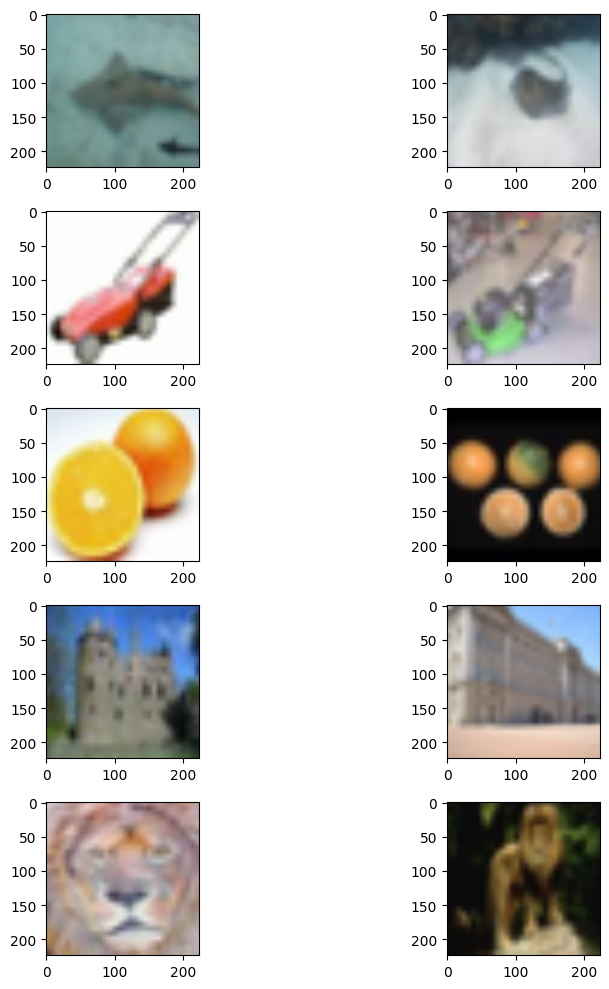

Different Class Pairs:


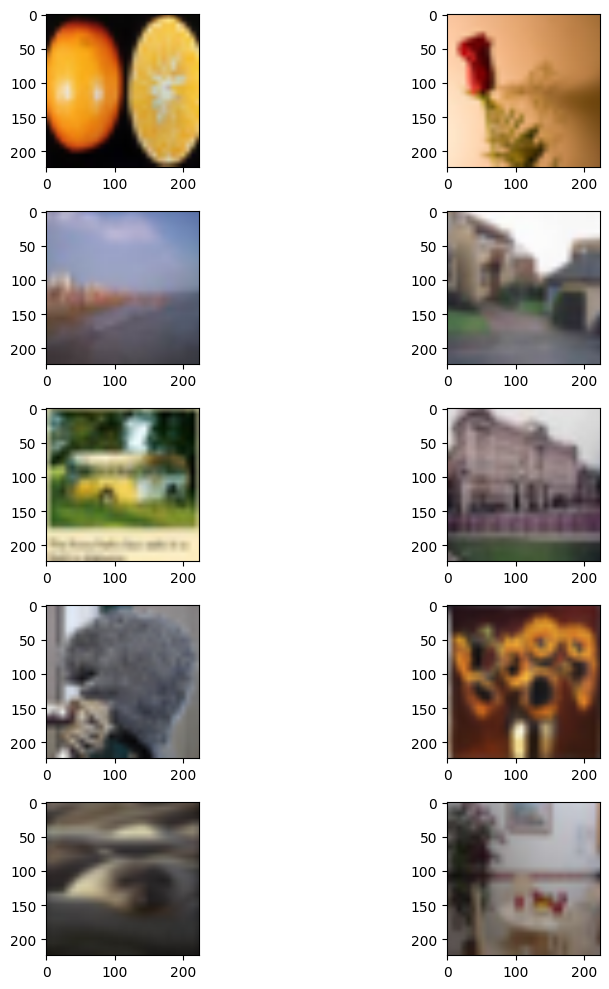


Epoch 1/10
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.704252
Train Epoch: 1 [1280/54000 (2%)]	Loss: 0.711107
Train Epoch: 1 [2560/54000 (5%)]	Loss: 0.689864
Train Epoch: 1 [3840/54000 (7%)]	Loss: 0.692021
Train Epoch: 1 [5120/54000 (9%)]	Loss: 0.694869
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.693657
Train Epoch: 1 [7680/54000 (14%)]	Loss: 0.688482
Train Epoch: 1 [8960/54000 (17%)]	Loss: 0.705821
Train Epoch: 1 [10240/54000 (19%)]	Loss: 0.699920
Train Epoch: 1 [11520/54000 (21%)]	Loss: 0.699792
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.686630
Train Epoch: 1 [14080/54000 (26%)]	Loss: 0.675519
Train Epoch: 1 [15360/54000 (28%)]	Loss: 0.681952
Train Epoch: 1 [16640/54000 (31%)]	Loss: 0.685727
Train Epoch: 1 [17920/54000 (33%)]	Loss: 0.678725
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.673736
Train Epoch: 1 [20480/54000 (38%)]	Loss: 0.659048
Train Epoch: 1 [21760/54000 (40%)]	Loss: 0.668422
Train Epoch: 1 [23040/54000 (43%)]	Loss: 0.665945
Train Epoch: 1 [24320/54000 (45%)]	Loss: 0.615361
Trai

KeyboardInterrupt: 

In [5]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from custom_dataset.one_shot_CIFAR_100 import SiameseCIFAR100
from utils.utils_func import display_image_pairs


# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function
loss_fn = nn.BCELoss()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

args = {
    'batch_size': 128,
    'epochs': 10,
    'lr': 0.01,
    'same_class_ratio': 0.5,
    'log_interval': 10,
    'seed': 42,
}

# Set random seed for reproducibility
torch.manual_seed(args['seed'])

# Define the Siamese ResNet model
class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Remove the original fully connected layer and add a new one
        self.resnet.fc = nn.Identity()  # Remove the original fc layer
        
        # Define a new fully connected layer for the Siamese network
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),  # 512 features for each image, and 2 images
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = self.fc(torch.cat((output1, output2), dim=1))
        output = torch.sigmoid(output)
        return output



def train(model, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (image_1, image_2, target) in enumerate(train_loader):
        image_1, image_2, target = image_1.to(device), image_2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(image_1, image_2)
        loss = loss_fn(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(image_1)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


def test(model, test_dataset):
    model.eval()
    correct = 0
    with torch.no_grad():
        for query_image, query_class in test_dataset:
            query_image = query_image.unsqueeze(0).to(device)
            predicted_class = None
            best_score = None
            
            for support_class, support_image in test_dataset.support_set.items():
                support_image = Image.fromarray(support_image)
                support_image = transform(support_image).unsqueeze(0).to(device)
                
                output = model(query_image, support_image).item()
                
                if best_score is None or output > best_score:
                    best_score = output
                    predicted_class = support_class

            if predicted_class == query_class.item():
                correct += 1

    accuracy = 100. * correct / len(test_dataset)
    print(f'Test Accuracy: {correct}/{len(test_dataset)} ({accuracy:.2f}%)')
    return accuracy


def main():
    # Define train and test datasets
    train_dataset = SiameseCIFAR100(root='../data', train=True, download=True, transform=transform, 
                                    classes_to_include=list(range(90)), same_class_ratio=args['same_class_ratio'])
    test_dataset = SiameseCIFAR100(root='../data', train=False, download=True, transform=transform, 
                                   classes_to_include=list(range(90, 100)))

    # Create DataLoader for training
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)

    # Initialize the model, optimizer
    model = SiameseResNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

    best_accuracy = 0

    # Display some example pairs from training
    display_image_pairs(train_dataset, num_pairs=5)

    # Train the model
    for epoch in range(1, args['epochs'] + 1):
        print(f'\nEpoch {epoch}/{args["epochs"]}')
        train(model, train_loader, optimizer, epoch, log_interval=args['log_interval'])

        # Test the model after each epoch
        accuracy = test(model, test_dataset)

        # Save the model if it has the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved Best Model with Accuracy: {best_accuracy:.2f}%')

    

if __name__ == '__main__':
    main()

